In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.integrate as integrate
from tqdm import tqdm

In [2]:
def SetStyle(ax,x,y,xlabel_,ylabel_,scale_=1., fontsize_=16):
    
    ticks_x = ticker.FuncFormatter(lambda x,pos:'{:.2f}'.format(x/scale_))
    ax.xaxis.set_major_formatter(ticks_x)

    ticks_y = ticker.FuncFormatter(lambda y,pos:'{:.2f}'.format(y/scale_))
    ax.yaxis.set_major_formatter(ticks_y)

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xlim(x[0],x[-1])
    ax.set_ylim(np.min(y),np.max(y))
    
    ax.set_xlabel(r'$'+xlabel_+'$',fontsize=fontsize_)
    ax.xaxis.set_label_coords(0.96, -0.1)

    if ylabel_ == '':
        ax.set_ylabel('',fontsize=fontsize_)
    else:    
        ax.set_ylabel(r'$'+ylabel_+'$',fontsize=fontsize_)
        
    ax.yaxis.set_label_coords(-0.1, 0.96)

    ax.legend(loc=1,prop={'size': 14})    

In [3]:
n = np.array([2])
b = np.array([3.5])
s = np.array([1])
NChannels = len(n)

In [4]:
# flat or linear priors
def prior(mu):
    
    if np.isscalar(mu):
        if mu > 0.:
            return 1
        else: return 0.
    else:
        if mu.any() > 0.:
            return 1.
        else:
            return 0.

In [5]:
def Likelihood(n,b,s,mu):
    lambda_ = mu*s+b
    return np.exp(-lambda_)*lambda_**n / np.math.factorial(n)

In [6]:
def JointLikelihood(mu):
    
    like = 1.0
    
    for c in range(NChannels):

        like *= Likelihood(n[c],b[c],s[c],mu)
        # Incluing the prior distribution
        like *= prior(mu)
        
    return like

In [7]:
JointLikelihood(0.9)

0.11884465026170248

In [8]:
# POI is the signal strength
mu = np.linspace(0.,10.,20)
L = JointLikelihood(mu)

In [9]:
def GetFigure(x,y,name_=''):
    
    fig = plt.figure(figsize=(6,6),dpi=100)
    ax = fig.add_subplot(1,1,1)
    
    ax.plot(x,y,'k',lw=2,label=r'$p(\mu)=\mathcal{L}(\mu) \pi(\mu)$')
    
    SetStyle(ax,x,y,xlabel_='\mu',ylabel_='')
    
    folder = '../Figures/'
    folder += name_
    
    plt.savefig(folder)

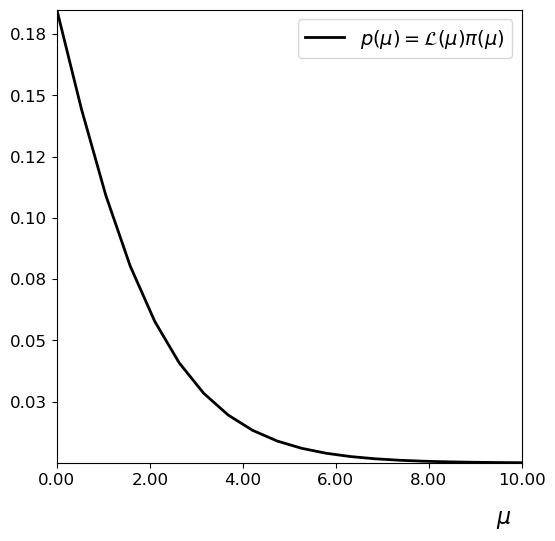

In [10]:
GetFigure(mu,L,name_='Bayesian_PosteriorDist.pdf')

In [11]:
Normalization = integrate.quad(JointLikelihood,mu[0],mu[-1])[0]
print(Normalization)

0.32070239130863476


In [12]:
def GetPValue(mu,JointLikelihood):
    
    pvalue = np.zeros(len(mu)-1)
    
    Normalization = integrate.quad(JointLikelihood,mu[0],mu[-1])[0]
    
    for i in tqdm(range(len(mu)-1)):
        pvalue[i] = 1.-integrate.quad(JointLikelihood,0,mu[i])[0]/Normalization
        
    return pvalue

In [13]:
pvalue = GetPValue(mu,JointLikelihood)

100%|██████████| 19/19 [00:00<00:00, 6301.24it/s]


In [14]:
def GetFigure1(x,y,name_=''):
    
    fig = plt.figure(figsize=(6,6),dpi=100)
    ax = fig.add_subplot(1,1,1)
    
    ax.plot(x,y,marker='o',color='k',lw=2,label=r'Observed limit')
    
    ax.axhline(y=0.05,ls='--',color='r',lw=2, label=r'$95\% \ CL$')
    
    SetStyle(ax,x,y,xlabel_='\mu',ylabel_='p-value')
    
   # ax.set_yscale('log')
    
    folder = '../Figures/'
    folder += name_
    
    plt.savefig(folder)

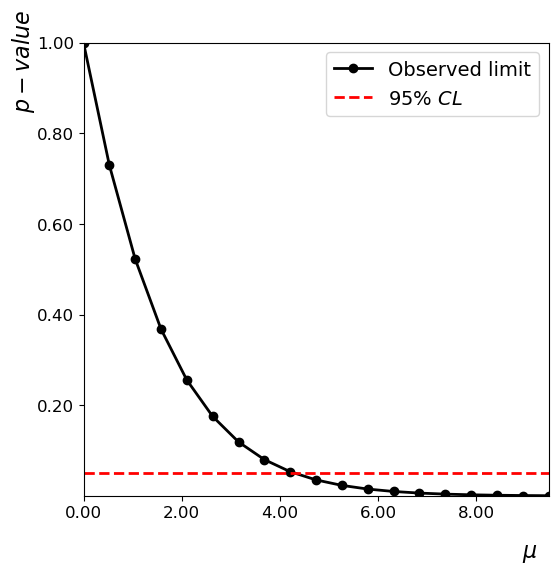

In [15]:
GetFigure1(mu[:-1],pvalue,'Bayesian_PvalueScan.pdf')

In [16]:
def GetUpperLimit(l,mu,p=0.05):
    
    i = np.where(l <= p)
    
    if len(i[0]) == 0:
        print('---No calculable---')
        return 0.
    else:
        i = i[0][0]
    
    x0 = mu[i-1]
    x1 = mu[i]
    y0 = l[i-1]
    y1 = l[i]
    
    # Calulamos pendiente
    m = (y1-y0)/(x1-x0)
    
    if m == 0.:
        print('---No calculable---')
        return 0.
        
    mup = (p - y0)/m + x0
    
    return mup

In [17]:
upperlimit = GetUpperLimit(pvalue,mu)

In [18]:
def GetFigure3(x,y,upper,name_=''):
    
    fig = plt.figure(figsize=(6,6),dpi=100)
    ax = fig.add_subplot(1,1,1)
    
    ax.plot(x,y,'k',lw=2,label=r'$p(\mu)=\mathcal{L}(\mu) \pi(\mu)$')
    
    ax.axvline( x = upper, color='r', linestyle='--', label=r'$\mu^{up}$: %.3f'%(upper) )
    
    upper_ = np.linspace(upper,np.max(x),100)
    ax.fill_between(upper_,0,JointLikelihood(upper_),color='b')
    
    SetStyle(ax,x,y,xlabel_='\mu',ylabel_='')
    
    folder = '../Figures/'
    folder += name_
    
    plt.savefig(folder)

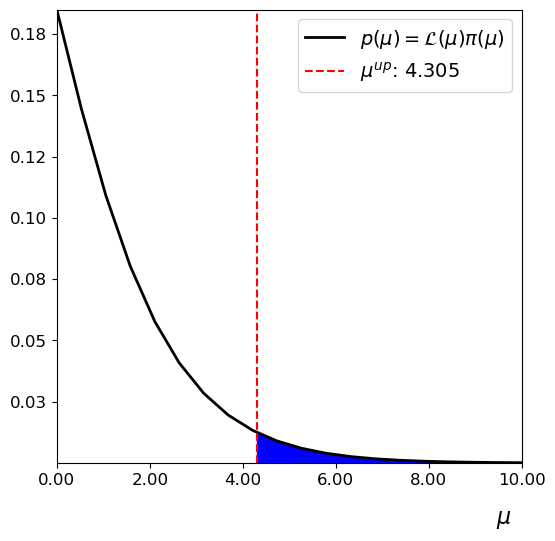

In [19]:
GetFigure3(mu,L,upperlimit,name_='Bayesian_PosteriorDist_UpperL.pdf')